In [24]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Q1.1

In [26]:
class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [27]:
# model = FashionMNISTNet()

# lambda_l2 = 0.0001
# learning_rate = 0.01
# num_epochs = 10

# criterion = nn.CrossEntropyLoss()

# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for data, target in train_loader:
#         output = model(data)
#         loss = criterion(output, target)
        
#         l2_reg = 0
#         for param in model.parameters():
#             l2_reg += torch.norm(param, 2) ** 2
#         loss += lambda_l2 * l2_reg
        
#         loss.backward()
#         with torch.no_grad():
#             for param in model.parameters():
#                 param -= learning_rate * param.grad
#                 param.grad.zero_()  # Manually zero the gradients
#         running_loss += loss.item()

#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


In [28]:
model = FashionMNISTNet()

criterion = nn.CrossEntropyLoss()

lambda_l2 = 0.0001
learning_rate = 0.01
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        l2_reg = 0
        for param in model.parameters():
            l2_reg += torch.sum(param ** 2)
        loss += lambda_l2 * l2_reg

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


Epoch [1/20], Loss: 1.2016
Epoch [2/20], Loss: 0.7606
Epoch [3/20], Loss: 0.6638
Epoch [4/20], Loss: 0.6054
Epoch [5/20], Loss: 0.5678
Epoch [6/20], Loss: 0.5429
Epoch [7/20], Loss: 0.5213
Epoch [8/20], Loss: 0.5078
Epoch [9/20], Loss: 0.4940
Epoch [10/20], Loss: 0.4820
Epoch [11/20], Loss: 0.4732
Epoch [12/20], Loss: 0.4660
Epoch [13/20], Loss: 0.4574
Epoch [14/20], Loss: 0.4506
Epoch [15/20], Loss: 0.4444
Epoch [16/20], Loss: 0.4392
Epoch [17/20], Loss: 0.4341
Epoch [18/20], Loss: 0.4307
Epoch [19/20], Loss: 0.4244
Epoch [20/20], Loss: 0.4219


In [29]:
# model = MLP()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)  # L2 regularization with weight_decay

# # 4. Training the Model
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0
#     for i, (images, labels) in enumerate(train_loader):
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [30]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


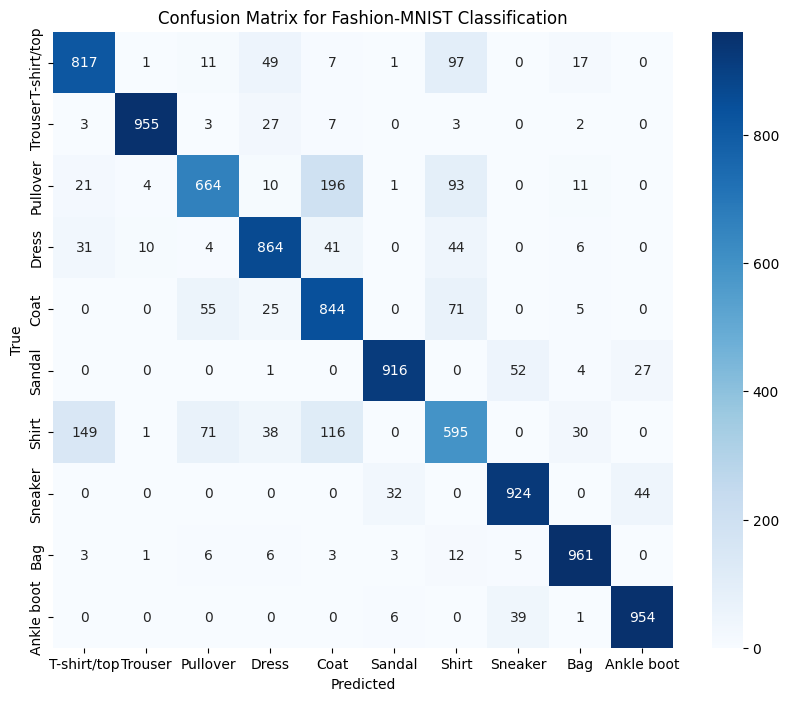

In [31]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Fashion-MNIST Classification')
plt.show()

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


In [33]:
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


conf_matrix[range(len(conf_matrix)), range(len(conf_matrix))] = 0  # Zero out diagonal
most_confused = np.unravel_index(conf_matrix.argmax(), conf_matrix.shape)
print(f'Two classes most confused with each other: {train_dataset.classes[most_confused[0]]} and {train_dataset.classes[most_confused[1]]}')


Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.82      0.66      0.73      1000
       Dress       0.85      0.86      0.86      1000
        Coat       0.70      0.84      0.76      1000
      Sandal       0.96      0.92      0.94      1000
       Shirt       0.65      0.59      0.62      1000
     Sneaker       0.91      0.92      0.91      1000
         Bag       0.93      0.96      0.94      1000
  Ankle boot       0.93      0.95      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Two classes most confused with each other: Pullover and Coat


# Q1.2

In [ ]:
class FashionMNISTNetWithoutDroput(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x